# CAPM for basic stock analysis

### About CAPM
How to evaluate the performance of your assets?
Optimize your portfolio by reviewing the statistics of your stocks.

The goal is to generate an objective measure to validate the potential win against the risk. This method is know as the CAPM method. What we would like to see:
- Risk?
- Opportunity?
- Is the asset over- or under valued? (undervalued = potential that it will do well in the future)

### Objectives
...

### Approach
1. Import libraries
2. Data and data preparation
2. Calculate Beta
3. Calculate the expected rate of return (CAPM method)
4. Interprete the results

## 1. Importing Libraries

In [1]:
import pandas_datareader as pdr
import numpy as np
import datetime as dt
import pandas as pd
from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## 2. Data

### Steps
- Get raw stock data of the market and the stocks of interest (can be 1 year, 3 years or other timeframe).
- Typically the S&P500 (Symbol "^GSPC") is used as the representation of the market data.
- Transform raw data into a dataframe with returns

In [3]:
tickers = ['XIC.TO', '^GSPC', 'SHOP', 'TSLA', 'VFV.TO', 'VDY.TO']
start = dt.datetime(2018, 12, 24)
end = dt.datetime(2021, 12, 24)
df_stocks = pdr.get_data_yahoo(tickers, start, end, interval="d")

df_stocks = df_stocks['Adj Close']

df_stocks

Symbols,XIC.TO,^GSPC,SHOP,TSLA,VFV.TO,VDY.TO
Date,,,,,,
2018-12-24,20.099085,2351.100098,119.099998,59.077999,54.506878,25.446144
2018-12-26,NaN,2467.699951,130.210007,65.218002,NaN,NaN
2018-12-27,20.646490,2488.830078,132.399994,63.226002,57.672100,26.051165
2018-12-28,20.764046,2485.739990,133.460007,66.774002,57.985271,26.280577
2018-12-31,20.929350,2506.850098,138.449997,66.559998,58.090950,26.368469
...,...,...,...,...,...,...
2021-12-20,32.810001,4568.020020,1282.170044,899.940002,105.099998,41.880001
2021-12-21,33.419998,4649.229980,1370.109985,938.530029,106.750000,42.380001
2021-12-22,33.660000,4696.560059,1385.630005,1008.869995,107.150002,42.680000


In [4]:
# Checking how many missing NaN
df_stocks.isna().sum()

Symbols
XIC.TO    15
^GSPC     13
SHOP      13
TSLA      13
VFV.TO    15
VDY.TO    15
dtype: int64

In [10]:
# Checking if there are double-dates (divident stocks might show date a second time for the divident value)
print(df_stocks.index.has_duplicates)
print(df_stocks.index.nunique())
print(len(df_stocks))

False
770
770


In [11]:
# No duplicated dates
# 1.9% NaN for specific stocks; it is not a big impact to fill these gaps
df_stocks.fillna(method="ffill", inplace=True)
df_stocks

Symbols,XIC.TO,^GSPC,SHOP,TSLA,VFV.TO,VDY.TO
Date,,,,,,
2018-12-24,20.099085,2351.100098,119.099998,59.077999,54.506878,25.446144
2018-12-26,20.099085,2467.699951,130.210007,65.218002,54.506878,25.446144
2018-12-27,20.646490,2488.830078,132.399994,63.226002,57.672100,26.051165
2018-12-28,20.764046,2485.739990,133.460007,66.774002,57.985271,26.280577
2018-12-31,20.929350,2506.850098,138.449997,66.559998,58.090950,26.368469
...,...,...,...,...,...,...
2021-12-20,32.810001,4568.020020,1282.170044,899.940002,105.099998,41.880001
2021-12-21,33.419998,4649.229980,1370.109985,938.530029,106.750000,42.380001
2021-12-22,33.660000,4696.560059,1385.630005,1008.869995,107.150002,42.680000


## 3. Calculating Beta
Beta expresses how "dynamic" an asset reacts to market fluctuations. A high beta means high risk, but also high opportunity, depending on the market.
- Beta < 1: More stable, but also less growth opportunity
- Beta > 1: More risky, but also higher win opportunity

### Calculating Beta - Method 1

In [14]:
# Generating dataframe with returns
df_returns = np.log(df_stocks / df_stocks.shift()) *100
df_returns.iloc[0] = 0
df_returns

Symbols,XIC.TO,^GSPC,SHOP,TSLA,VFV.TO,VDY.TO
Date,,,,,,
2018-12-24,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2018-12-26,0.000000,4.840318,8.918512,9.887695,0.000000,0.000000
2018-12-27,2.687105,0.852623,1.667901,-3.101990,5.644663,2.349825
2018-12-28,0.567759,-0.124235,0.797426,5.459818,0.541552,0.876766
2018-12-31,0.792956,0.845663,3.670737,-0.321005,0.182085,0.333881
...,...,...,...,...,...,...
2021-12-20,-0.970586,-1.145340,-3.165021,-3.561613,-0.814939,-0.500177
2021-12-21,1.842108,1.762176,6.633703,4.198676,1.557739,1.186817
2021-12-22,0.715572,1.012873,1.126390,7.227131,0.374008,0.705386


In [31]:
def calc_beta(df, i):
    '''Function to calculate Beta (first method)
    Input: Dataframe with returns
    Output: Beta values for each stock'''
    cov = df.cov()
    var = df['^GSPC'].var()

    return cov.loc[i, '^GSPC'] / var

In [33]:
for i in df_returns.columns:
    if i != '^GSPC':
        print('Beta for {} is {:1.2}'.format(i, calc_beta(df_returns, i)))

Beta for XIC.TO is 0.77
Beta for SHOP is 1.2
Beta for TSLA is 1.3
Beta for VFV.TO is 0.84
Beta for VDY.TO is 0.83


### Calculating Beta - Method 2

In [34]:
def calc_return(df):
    '''Function to generate a detaframe with returns
    - Input: Dataframe with raw stock data
    - Output: Dataframe with returns'''

    x = df.copy()
    
    for i in range(1, len(df)):
        x.iloc[i] = (df.iloc[i] - df.iloc[i-1]) / df.iloc[i-1] * 100

    x.iloc[0] = 0

    return x

In [35]:
df_returns_alt = calc_return(df_stocks)
df_returns_alt

Symbols,XIC.TO,^GSPC,SHOP,TSLA,VFV.TO,VDY.TO
Date,,,,,,
2018-12-24,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2018-12-26,0.000000,4.959374,9.328303,10.393045,0.000000,0.000000
2018-12-27,2.723533,0.856268,1.681889,-3.054372,5.807014,2.377651
2018-12-28,0.569373,-0.124158,0.800614,5.611616,0.543021,0.880621
2018-12-31,0.796108,0.849248,3.738940,-0.320491,0.182251,0.334439
...,...,...,...,...,...,...
2021-12-20,-0.965891,-1.138806,-3.115459,-3.498934,-0.811628,-0.498929
2021-12-21,1.859179,1.777793,6.858680,4.288067,1.569935,1.193887
2021-12-22,0.718138,1.018020,1.132757,7.494695,0.374709,0.707879


In [37]:
def calc_beta_alt(df, i):
    '''Function to calculate Beta (second method)
    Input: Dataframe with returns
    Output: Beta values for each stock'''

    return np.polyfit(df['^GSPC'], df_returns_alt[i], 1) # first position is Beta, second position is Alpha

In [39]:
for i in df_returns_alt.columns:
    if i != '^GSPC':
        print('Beta for {} is {:1.2}'.format(i, calc_beta_alt(df_returns_alt, i)[0]))

Beta for XIC.TO is 0.76
Beta for SHOP is 1.2
Beta for TSLA is 1.3
Beta for VFV.TO is 0.84
Beta for VDY.TO is 0.82


The results are slightly different, but close enough for the evaluation. This means it doesn't matter which methods are used in this case.

### Visualizing Beta

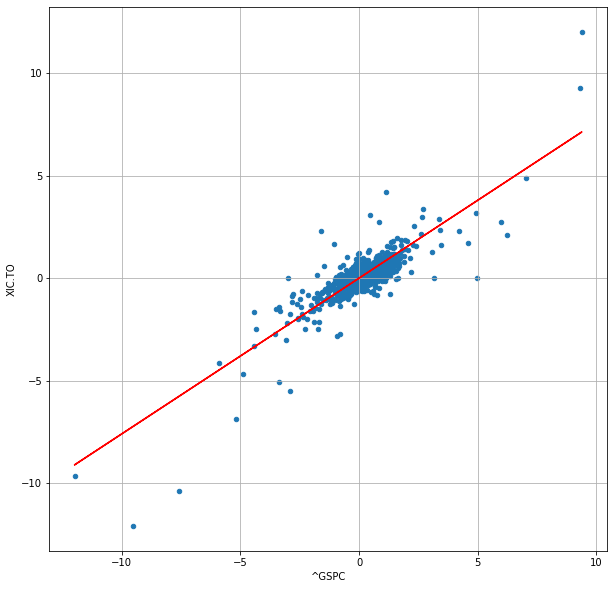

In [54]:
df_returns_alt.plot(kind='scatter', x = '^GSPC', y='XIC.TO', figsize=(10, 10))
plt.plot(df_returns_alt['^GSPC'], calc_beta_alt(df_returns_alt, 'XIC.TO')[0] * df_returns_alt['^GSPC'] + calc_beta_alt(df_returns_alt, 'XIC.TO')[1], '-', color='red')
plt.grid();

The above graph shows beta and alpha represented by the red line. Beta is the line's slope, alpha it's intercept. This is an example of a relatively stable stock (XIC) because the slope is less than 1. 

## 4. Calculating the Expected Rate of Return
The expected rate of return expresses a potential return rate that considers the relation to a risk free asset, the relation to the market (in our case S&P 500), and the Beta indicator.

The Expected Rate of Return can then compared with the rate based on the observed (historical) data.
Interpretation:
- Expected Rate of Return is higher than the observed: The asset is Overvalued
- Expected Rate of Return is lower than the observed: The asset is Undervalued

The general advice is to aquire undervalued assets.

<img src="https://capital.com/files/glossary/[Infographic]%20Capital%20asset%20pricing%20model.png" width="750">

### Process
- Calculate the average market return value (rm) for a year
- Obtain the risk free rate (rf) for a year
- Calculate the stock's Beta (beta) rate
- Calculate the Expected rate (ER or R) for the stock
- Evaluate the ER based in comparison with the observed rate

### Calculating the market return rate rm
The S&P 500 stock (symbol: ^GSPC) is often used as a representation of the market.

In [56]:
# Extracting S&P500 return rates and transform into a yearly return rate.
# Total 3-year dataset has 770 rows => 257 days per year; potentially a simplification but close enough
rm = ((1 + df_returns['^GSPC'].mean() / 100) ** 257 - 1) * 100
print('The rm rate is {:4.4}.'.format(rm))

The rm rate is 26.23.


### Obtaining the risk free rate rf
Mostly the rf rate is extracted from the [US government tresury bond](https://www.treasury.gov/resource-center/data-chart-center/interest-rates/Pages/TextView.aspx?data=billratesAll).

The value can be calculated, but for simplicity, we will take a rate of 1.5.

In [57]:
# Just googled
rf = 1.5

### Calculating the Expected Rate of Return based on CAPM

In [58]:
def calc_er(df):
    '''Function to calculate the expected rate of return
    Input: Dataframe with historical retuns
    Output: Dictionary containing expected returns for each contained stock
    '''
    dict_er = {}

    for i in df.columns:
        if i != '^GSPC':
            dict_er[i] = rf + calc_beta(df, i) * (rm - rf)

    return dict_er

In [76]:
dict_er = calc_er(df_returns)
for i in dict_er.keys():
    print('Expected rate of return for {} is {:2.4}%'.format(i, dict_er[i]))

Expected rate of return for XIC.TO is 20.43%
Expected rate of return for SHOP is 30.72%
Expected rate of return for TSLA is 34.74%
Expected rate of return for VFV.TO is 22.17%
Expected rate of return for VDY.TO is 21.98%


## 5. Output interpretation

In [78]:
for i in df_returns.columns:
    if i != '^GSPC':
        r_hist = ((1 + df_returns[i].mean() / 100) ** 257 - 1) * 100
        if r_hist > dict_er[i]:
            print('{} \n   Expected rate based on CAPM: {:2.4}% \n   Historical: {:2.4}% \n   The stock is undervalued.'.format(i, dict_er[i], r_hist))
        else:
            print('{} \n   Expected rate based on CAPM: {:2.4}% \n   Historical: {:2.4}% \n   The stock is overvalued.'.format(i, dict_er[i], r_hist))

XIC.TO 
   Expected rate based on CAPM: 20.43% 
   Historical: 19.1% 
   The stock is overvalued.
SHOP 
   Expected rate based on CAPM: 30.72% 
   Historical: 129.4% 
   The stock is undervalued.
TSLA 
   Expected rate based on CAPM: 34.74% 
   Historical: 162.2% 
   The stock is undervalued.
VFV.TO 
   Expected rate based on CAPM: 22.17% 
   Historical: 25.52% 
   The stock is undervalued.
VDY.TO 
   Expected rate based on CAPM: 21.98% 
   Historical: 19.14% 
   The stock is overvalued.
